This is in development

In [181]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as signal
import os
import torch
from torch import nn
import copy

fn = os.path.join('..', 'data', 'BP_data.pkl')
df = pd.read_pickle(fn)
df = df[df['DiastolicP']>30]  # trow out outlier
df = df.reset_index(drop = True)

print(df.columns)
print(df.info())

Index(['SubjectID', 'Condition', 'Age', 'Gender', 'Height', 'Weight',
       'SystolicP', 'DiastolicP', 'MeanP', 'CuffP', 'Amplitude', 'Area',
       'brachial_waveform', 'dc_cuff_pressure', 'cuff_pressure_oscillations'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SubjectID                   193 non-null    object 
 1   Condition                   193 non-null    object 
 2   Age                         193 non-null    int64  
 3   Gender                      193 non-null    object 
 4   Height                      193 non-null    float64
 5   Weight                      193 non-null    float64
 6   SystolicP                   193 non-null    float64
 7   DiastolicP                  193 non-null    float64
 8   MeanP                       193 non-null    float64
 9   CuffP              

In [182]:
df['CuffP'].iloc[0]

array([ 78.0799  ,  79.37099 ,  80.66207 ,  81.95315 ,  83.24423 ,
        84.53532 ,  85.8264  ,  87.117485,  88.40857 ,  89.69965 ,
        90.99073 ,  92.281815,  93.5729  ,  94.86398 ,  96.15507 ,
        97.44615 ,  98.737236, 100.02832 , 101.3194  , 102.61048 ,
       103.901566, 105.19265 , 106.483734, 107.77482 , 109.0659  ,
       110.35699 , 111.64806 , 112.93915 , 114.23023 , 115.52132 ,
       116.8124  , 118.103485, 119.39457 , 120.685646, 121.97673 ,
       123.267815, 124.5589  , 125.84998 , 127.14107 , 128.43214 ,
       129.72324 , 131.01431 , 132.3054  , 133.59648 , 134.88757 ,
       136.17865 , 137.46973 , 138.76082 , 140.0519  , 141.34299 ,
       142.63406 , 143.92516 , 145.21623 , 146.50731 , 147.7984  ,
       149.08948 , 150.38057 , 151.67165 , 152.96274 , 154.25381 ,
       155.54489 , 156.83598 , 158.12706 , 159.41815 , 160.70923 ,
       162.00032 , 163.2914  , 164.58247 , 165.87357 , 167.16464 ,
       168.45573 , 169.74681 , 171.0379  , 172.32898 , 173.620

In [183]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
    device = 'cuda'
else:
    print("No GPU available. Training will run on CPU.")
    device = 'cpu'

GPU: NVIDIA GeForce RTX 3070 is available.


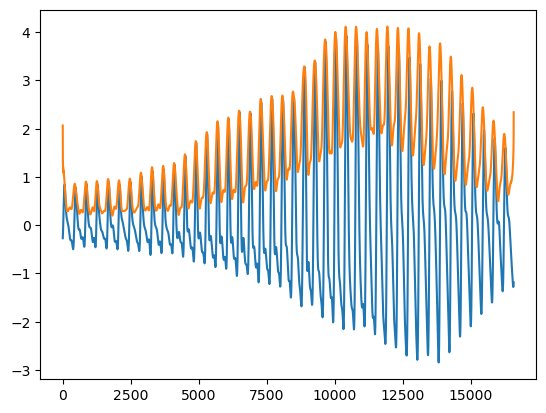

In [184]:
import scipy

def get_signal_envelope(signal):
    signal = scipy.signal.detrend(signal)
    analytic_signal = scipy.signal.hilbert(signal)  

    envelope = np.abs(analytic_signal)  

    return envelope


fig, ax = plt.subplots()


for idx in df.index:
    x = df.loc[idx, 'cuff_pressure_oscillations']
    ax.plot(x)

    x = get_signal_envelope(x)
    ax.plot(x)
    break

In [185]:
print(np.max(df['Amplitude'].apply(np.max)))
print(np.max(df['Area'].apply(np.max)))
print(np.max(df['dc_cuff_pressure'].apply(np.max)))

8.290167808532715
3.9556119441986084
248.592753089655


In [186]:
from torch.utils.data import Dataset, DataLoader

class Datset(Dataset):
    def __init__(self, df, device = device):
        self.df = df 
        self.device = device
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, i):

        idx = self.df.index[i]

        SP = self.df.at[idx, 'SystolicP']
        DP = self.df.at[idx, 'DiastolicP']
        MP = self.df.at[idx, 'MeanP']

        y = torch.empty(1, 3, device = self.device, dtype = torch.float32)
        y[0, 0] = SP /250.0
        y[0, 1] = MP /250.0
        y[0, 2] = DP/250.0

        # x1 = self.df.loc[idx, 'dc_cuff_pressure']  /250.0
        # x2 = self.df.loc[idx, 'cuff_pressure_oscillations'] / 6.0
        #x = np.stack([x1, x2], axis = -1)

        #x1 = self.df.loc[idx, 'Amplitude']  /10.0
        #x2 = self.df.loc[idx, 'Area'] / 4.0
        x3 = (self.df.loc[idx, 'CuffP'] + self.df.loc[idx, 'Amplitude']) / 250.0
        x = np.stack([ x3], axis = -1)

        x = torch.tensor(x, device = self.device, dtype = torch.float32)
        return x, y
    
def collate_fn(mylist):
    #print(mylist)
    min_length = min([len(x[0]) for x in mylist])
    #print(min_length)
    xx = [x[:min_length] for x,y in mylist]
    yy = [y for x,y in mylist]

    xx = torch.stack(xx, axis = 0)
    yy = torch.stack(yy, axis = 0)

    return (xx, yy)

dataset_test = Datset(df.iloc[:50])
dataset_train = Datset(df.iloc[50:])
dataloader_test = DataLoader(dataset_test, batch_size=20, shuffle=True, collate_fn = collate_fn)
dataloader_train = DataLoader(dataset_train, batch_size=50, shuffle=True, collate_fn = collate_fn)


for x, y in dataloader_test:
    print("Batch of x has shape (sample, timepoints, features): ", x.shape)
    print("Batch of y has shape (sample, timepoints, targets): ", y.shape)
    break

Batch of x has shape (sample, timepoints, features):  torch.Size([20, 100, 1])
Batch of y has shape (sample, timepoints, targets):  torch.Size([20, 1, 3])


In [187]:
def data_mutate(x, y):

    offset = (torch.rand(1, device = device)-0.5) * 5 #TODO: remove times 0
    #print(offset)

    x[:, :, 0] = x[:, :, 0] + offset
    y = y + offset
    return x, y

for x, y in dataloader_test:
    x, y = data_mutate(x, y)
    print("Batch of x has shape (sample, timepoints, features): ", x.shape)
    print("Batch of y has shape (sample, timepoints, targets): ", y.shape)

    break



Batch of x has shape (sample, timepoints, features):  torch.Size([20, 100, 1])
Batch of y has shape (sample, timepoints, targets):  torch.Size([20, 1, 3])


In [188]:
class neural_network(nn.Module):
    def __init__(self, input_size , output_size, hidden_size = 10, num_layers = 2):
        super(neural_network,self).__init__()
        self.conv = torch.nn.Conv1d(in_channels = input_size, out_channels = hidden_size, kernel_size = 200)
        self.pool = torch.nn.MaxPool1d(50)
        self.fc0 = nn.Linear(in_features=input_size,out_features=hidden_size)
        #self.rnn = nn.LSTM(input_size=hidden_size,hidden_size=hidden_size,num_layers=num_layers,batch_first=True, bidirectional=True)
        self.rnn = nn.GRU(input_size=hidden_size,hidden_size=hidden_size,num_layers=num_layers,batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(in_features=2*hidden_size,out_features=output_size)
        self.dropout = nn.Dropout(p = .1)
        self.act = torch.relu
    def forward(self,x):
        output = x

        # output = output.permute(0, 2, 1)
        # output = self.conv(output)
        # output = self.pool(output)
        # output = output.permute(0, 2, 1)
        #print(output.shape)

        output = self.fc0(output)
        output = self.act(output)
        output = self.dropout(output)
        output,_status = self.rnn(output)

        #o1 = torch.max(output, dim = 1, keepdim=True)[0]
        #o2 = torch.min(output, dim = 1, keepdim=True)[0]
        #o3 = torch.mean(output, dim = 1, keepdim=True)  
        #output = torch.cat([o1, o2, o3], dim = 2)
        #print(o1.shape, output.shape)

        output = output[:,[-1],:]
        output = self.dropout(output)
        #print(output.shape)
        output = self.fc1(self.act(output))
        return output




In [189]:
N_features = 1
N_targets = 3

model = neural_network(input_size = N_features, output_size = N_targets)
model.to(device)
model.train()


optimizer = torch.optim.RMSprop(model.parameters(),lr=0.001)
loss = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',  factor=0.9, patience=10)

epochs = 10000

losses_train = []
losses_test = []
no_improvement_count = 0
loss_to_beat = 1.0

model_best = copy.deepcopy(model)

for i in range(epochs):

        loss_train = 0
        model.train()
        optimizer.zero_grad() 

        for XX_train, YY_train in dataloader_train:
                XX_train, YY_train = data_mutate(XX_train, YY_train)
                YY_pred_train = model(XX_train)
                loss_train += loss(YY_pred_train,YY_train)
        loss_train.backward()
        optimizer.step()

        with torch.no_grad():
                loss_test = 0
                model.eval()
                for XX_test, YY_test in dataloader_test:
                        YY_pred_test = model(XX_test)
                        loss_test += loss(YY_pred_test,YY_test)
                scheduler.step(loss_test)

        if i%1 ==0:
                print(f'{i}, train loss = {loss_train:.3e}, test loss = {loss_test:.3e}, loss_to_beat = {loss_to_beat:.3e}, no improvement for epochs = {no_improvement_count}, lr = {scheduler.get_last_lr()[0]:.2e}')
        
        loss_train = loss_train.cpu().detach().numpy()
        loss_test = loss_test.cpu().detach().numpy()

        if loss_test < loss_to_beat and i>20:
                loss_to_beat = 0.9*loss_to_beat + 0.1*loss_test
                no_improvement_count = 0
                model_best = copy.deepcopy(model)

        else:
                no_improvement_count = no_improvement_count+1

        if no_improvement_count > 2000:  # early stopping
                print('early stopping activated')
                break

        losses_train.append(loss_train)
        losses_test.append(loss_test)

0, train loss = 5.806e+00, test loss = 6.139e-01, loss_to_beat = 1.000e+00, no improvement for epochs = 0, lr = 1.00e-03
1, train loss = 2.558e+00, test loss = 5.278e-01, loss_to_beat = 1.000e+00, no improvement for epochs = 1, lr = 1.00e-03
2, train loss = 5.140e+00, test loss = 6.021e-01, loss_to_beat = 1.000e+00, no improvement for epochs = 2, lr = 1.00e-03
3, train loss = 4.976e+00, test loss = 6.311e-01, loss_to_beat = 1.000e+00, no improvement for epochs = 3, lr = 1.00e-03
4, train loss = 3.980e+00, test loss = 5.683e-01, loss_to_beat = 1.000e+00, no improvement for epochs = 4, lr = 1.00e-03
5, train loss = 4.733e+00, test loss = 4.875e-01, loss_to_beat = 1.000e+00, no improvement for epochs = 5, lr = 1.00e-03
6, train loss = 2.382e+00, test loss = 4.836e-01, loss_to_beat = 1.000e+00, no improvement for epochs = 6, lr = 1.00e-03
7, train loss = 5.220e+00, test loss = 5.348e-01, loss_to_beat = 1.000e+00, no improvement for epochs = 7, lr = 1.00e-03
8, train loss = 7.058e+00, test 

KeyboardInterrupt: 

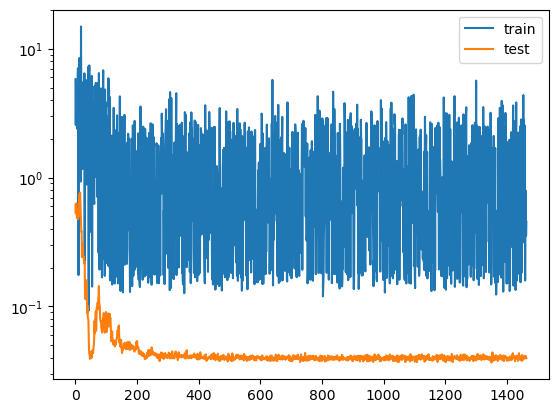

In [190]:
fig, ax = plt.subplots(1, 1)
ax.plot(losses_train, label = 'train')
ax.plot(losses_test, label = 'test')
ax.legend()
ax.set_yscale('log')

In [191]:
model_best.rnn.flatten_parameters()

ya_test = []
yp_test = []

ya_train = []
yp_train = []

with torch.no_grad():
        model_best.eval()

        for XX_train, YY_train in dataloader_train:
                ya_train.append(YY_train)
                yp_train.append(model_best(XX_train))

        for XX_test, YY_test in dataloader_test:
                ya_test.append(YY_test)
                yp_test.append(model_best(XX_test))
               

In [192]:
ya_test = torch.concat(ya_test, axis = 0).squeeze().cpu().numpy()*250
yp_test = torch.concat(yp_test, axis = 0).squeeze().cpu().numpy()*250
ya_train = torch.concat(ya_train, axis = 0).squeeze().cpu().numpy()*250
yp_train = torch.concat(yp_train, axis = 0).squeeze().cpu().numpy()*250

In [193]:
print(ya_test.shape, yp_test.shape, ya_train.shape, yp_train.shape)

(50, 3) (50, 3) (143, 3) (143, 3)


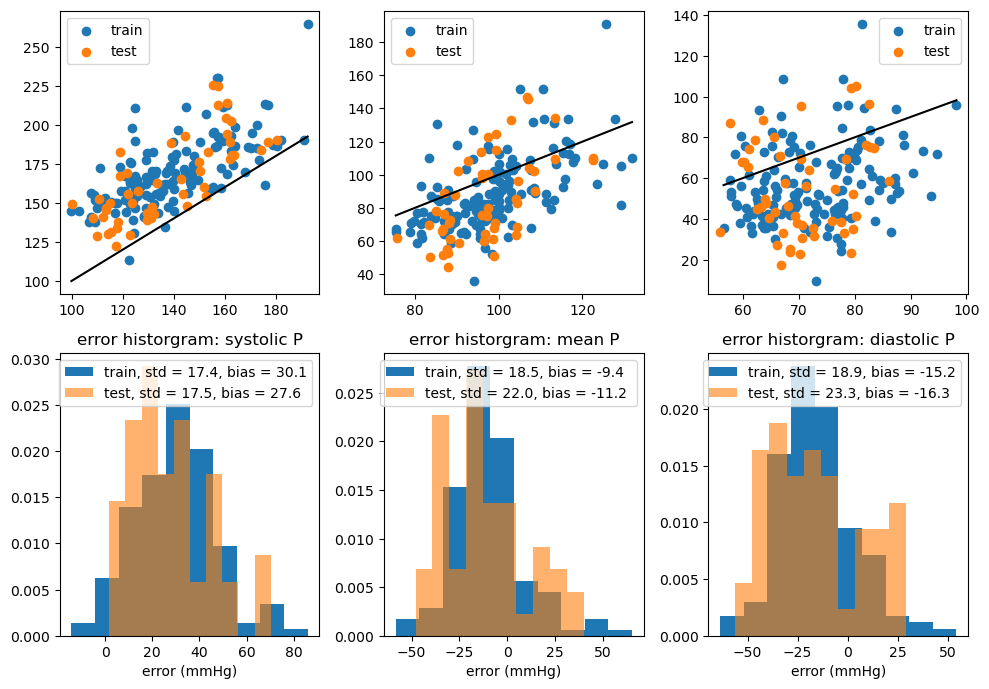

In [194]:

def t2n(x):
    return x.cpu().detach().numpy()



def calculate_error(yp, ya):
    error = yp - ya
    std_error = np.std(error, axis = 0)
    bias_error = np.mean(error, axis = 0)

    return error, std_error, bias_error

error_train, std_error_train, bias_error_train = calculate_error(yp_train, ya_train)
error_test, std_error_test, bias_error_test = calculate_error(yp_test, ya_test)


targets = ['systolic P', 'mean P', 'diastolic P']
fig, ax = plt.subplots(2, N_targets)

for i in range(N_targets):


    ax[0,i].scatter(ya_train[:,i], yp_train[:,i], label = 'train')
    ax[0,i].scatter(ya_test[:,i], yp_test[:,i], label = 'test')
    ax[0,i].plot([np.min(ya_train[:,i]), np.max(ya_train[:,i])], [np.min(ya_train[:,i]), np.max(ya_train[:,i])], color = 'k')
    ax[0,i].legend()


    
    ax[1,i].hist(error_train[:, i], label = f'train, std = {std_error_train[i]:.1f}, bias = {bias_error_train[i]:.1f}', density = True, alpha = 1)
    ax[1,i].hist(error_test[:, i], label = f'test, std = {std_error_test[i]:.1f}, bias = {bias_error_test[i]:.1f} ', density = True, alpha = .6)
    ax[1,i].set_xlabel('error (mmHg)')
    ax[1,i].set_title(f'error historgram: {targets[i]}')
    ax[1,i].legend()


fig.set_size_inches(10, 7)
fig.tight_layout()

In [195]:
std_error_train

array([17.387573, 18.49975 , 18.881031], dtype=float32)